In [1]:
import sys
import pickle
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix


In [2]:


def provide_confusion_matrix(GoldLabel, PredictLabel, label_set):
    """
    use `sklearn.metric confusion_matrix` to create confusion matrix of model predict.
    and `sklearn.metric ConfusionMatrixDisplay` to display created confusion matrix.

    Parameters
    ----------
    GoldLabel : list
        list of all Gold labels
    PredictLabel : list
        list of all Prediction labels
    label_set : list
        list of all classes

    Returns
    -------
        Confusion matrix
    """
    cf_matrix = confusion_matrix(GoldLabel, PredictLabel) # create a confusion matrix with gold and predicts
    print(cf_matrix) # print confusion_matrix as text
    display = ConfusionMatrixDisplay(confusion_matrix=cf_matrix, display_labels=label_set) # create graphical confusion_matrix
    fig, ax = plt.subplots(figsize=(15,15))
    # display.plot(ax=ax)
    display.plot(ax =ax) # show confusion_matrix
    plt.xticks(rotation=90)
    plt.show()
    return cf_matrix # return confusion_matrix (maybe useful later)

def calculate_precision_recall_f1score(GoldLabel, PredictLabel, label_set): # function get gold and predict and set of labels
    """
    use `sklearn.metric classification_report` to get report of model predict.

    Parameters
    ----------
    GoldLabel : list
        list of all Gold labels
    PredictLabel : list
        list of all Prediction labels
    label_set : list
        list of all classes

    Returns
    -------
        Classification report
    """
    report = classification_report(GoldLabel, PredictLabel, digits = 3, target_names=label_set) # calculate report
    print(report) # print report
    return report # return report (maybe useful later)

# def evaluation_model(GoldLabel, PredictLabel): # get gold and predict
def evaluation_model(GoldLabel, PredictLabel): # get gold and predict
    """
    Evaluation models by call `calculate_precision_recall_f1score` and `provide_confusion_matrix` functions.

    Parameters
    ----------
    GoldLabel : list
        list of all Gold labels
    PredictLabel : list
        list of all Prediction labels

    Returns
    -------
        Classification report and Confusion matrix
    """

    # GoldLabel = extract_golds_from_data(data)

    label_set = sorted(set(GoldLabel)) # find uniqe lables in gold
    print(label_set)

    print('precision_recall_f1-score')
    report = calculate_precision_recall_f1score(GoldLabel, PredictLabel, label_set) # calculate_precision_recall_f1score

    print('Confusion matrix')
    cf_matrix = provide_confusion_matrix(GoldLabel, PredictLabel, label_set) # provide_confusion_matrix

    return report, cf_matrix # return report and cf_matrix


In [3]:

def load_data(file_path):
    with open(file_path.replace('.conllu', '.preprocessed.pkl'), 'rb') as pickle_file:
        return pickle.load(pickle_file)


In [4]:
def save_data(data, file_path):
    with open(file_path, 'wb') as pickle_file:
        pickle.dump(data, pickle_file)

In [5]:
def load_model_data(file_path):
    with open(file_path, 'rb') as pickle_file:
       return pickle.load(pickle_file)

In [6]:
def get_all_sentences(data):
	word_list = []
	for sents in data:
		for word in sents:
			for f in word['features']:
				word[f]=word['features'][f]
			word_list.append(word)
	return word_list

In [7]:
def read_data_and_convert_to_df(path):
    data = load_data(path)
    data_frame = pd.DataFrame(get_all_sentences(data))
    return data_frame


In [8]:
def extract_features_and_golds (dataframe):
    dataframe = dataframe.drop(columns=['id','features', 'Definite', 'PronType', 'Number', 'Mood','Person', 'Tense', 'VerbForm','head','dependency_graph',
                                  'miscellaneous','prev_token_morph_features', 'next_token_morph_features','upos','xpos','pos_misc_feature',
                                  'NumType','Degree', 'Case', 'Gender', 'Poss', 'Voice', 'Foreign', 'Reflex', 'Typo','Abbr','form','lemma'])
    golds = dataframe['argument'].copy()
    dataframe= dataframe.drop(columns =['argument'])
    return dataframe, golds

In [9]:
def one_hot_dense_features(dataset_list, vec=None):

    newdf = pd.DataFrame(dataset_list,columns=['dependency_relation', 'pos_extracted',
       'position_rel2pred', 'head_pos', 'dep_path', 'ner'])

    if vec is None:
        vectorizer = DictVectorizer() #one-hot
        vecdata = vectorizer.fit_transform(newdf.to_dict(orient='records'))

    else:
        vectorizer = vec
        vecdata = vectorizer.transform(newdf.to_dict(orient='records'))

    return vecdata , vectorizer


In [10]:
# append all features into one vector
def features_to_vector(data):
    newdf = pd.DataFrame(data,columns=['embedding', 'embedding_head', 'num_of_children',
       'punct_extracted', 'sparse_fetures'])
    
    em_Array = np.array(data['embedding'])
    em_head_Array = np.array(data['embedding_head'])
    num_child_Array = np.array(data['num_of_children'])
    punch_Array = np.array(data['punct_extracted'])
    dsparse_Array = np.array(data['sparse_fetures'])

    em_Array = np.vstack(em_Array)
    em_head_Array = np.vstack(em_head_Array)
    num_child_Array = np.vstack(num_child_Array)
    punch_Array = np.vstack(punch_Array)
    dsparse_Array = np.vstack(dsparse_Array)

    featureVector = np.append(em_Array,em_head_Array, axis=1)
    featureVector = np.append(featureVector,num_child_Array, axis=1)
    featureVector = np.append(featureVector,punch_Array, axis=1)
    featureVector = np.append(featureVector,dsparse_Array, axis=1)
    
    return featureVector

In [14]:
train_file_path = 'data/en_ewt-up-train.conllu'
train_df = read_data_and_convert_to_df(train_file_path)
train_df, train_golds = extract_features_and_golds(train_df)

In [15]:
train_df.head()

,dependency_relation,predicate,embedding,pos_extracted,position_rel2pred,embedding_head,num_of_children,punct_extracted,head_pos,dep_path,cosine_similarity_w_predicate,head_pp_feature,ner,propbank_arg
0,root,kill.01,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",PROPN,Before,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",5,0,root,_,[[0.0]],PP-at,PERSON,0_1_2
1,punct,kill.01,"[-0.52482, -0.31963, -0.11898, -0.62672, 0.043...",PUNCT,Before,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0,1,PROPN,[HYPH],[[0.2082173]],PP-in,_,0_1_2
2,flat,kill.01,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",PROPN,Before,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0,0,PROPN,[NNP],[[0.0]],PP-of,_,0_1_2
3,punct,kill.01,"[0.43607, 1.5253, -0.11532, 0.33558, 0.36617, ...",PUNCT,Before,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0,1,PROPN,[:],[[0.3154642]],PP-near,_,0_1_2
4,amod,kill.01,"[0.15796, 0.012358, 0.1681, -0.81207, 0.34308,...",ADJ,Before,"[0.12051, -0.66653, 0.33663, -0.048388, 0.3260...",0,0,NOUN,"[JJ, NNS, VBD]",[[0.27067295]],NaN,NORP,0_1_2


In [16]:
train_dense ,vec = one_hot_dense_features(train_df)

In [17]:
train_df['sparse_fetures'] = train_dense.toarray().tolist()
train_df.head()

,dependency_relation,predicate,embedding,pos_extracted,position_rel2pred,embedding_head,num_of_children,punct_extracted,head_pos,dep_path,cosine_similarity_w_predicate,head_pp_feature,ner,propbank_arg,sparse_fetures
0,root,kill.01,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",PROPN,Before,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",5,0,root,_,[[0.0]],PP-at,PERSON,0_1_2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,punct,kill.01,"[-0.52482, -0.31963, -0.11898, -0.62672, 0.043...",PUNCT,Before,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0,1,PROPN,[HYPH],[[0.2082173]],PP-in,_,0_1_2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,flat,kill.01,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",PROPN,Before,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0,0,PROPN,[NNP],[[0.0]],PP-of,_,0_1_2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,punct,kill.01,"[0.43607, 1.5253, -0.11532, 0.33558, 0.36617, ...",PUNCT,Before,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0,1,PROPN,[:],[[0.3154642]],PP-near,_,0_1_2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ..."
4,amod,kill.01,"[0.15796, 0.012358, 0.1681, -0.81207, 0.34308,...",ADJ,Before,"[0.12051, -0.66653, 0.33663, -0.048388, 0.3260...",0,0,NOUN,"[JJ, NNS, VBD]",[[0.27067295]],NaN,NORP,0_1_2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [ ]:
newdf = pd.DataFrame(train_df,columns=['embedding', 'embedding_head', 'num_of_children',
       'punct_extracted', 'sparse_fetures'])
newdf.head()

,embedding,embedding_head,num_of_children,punct_extracted,sparse_fetures
0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",5,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,"[-0.52482, -0.31963, -0.11898, -0.62672, 0.043...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0,1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,"[0.43607, 1.5253, -0.11532, 0.33558, 0.36617, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0,1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ..."
4,"[0.15796, 0.012358, 0.1681, -0.81207, 0.34308,...","[0.12051, -0.66653, 0.33663, -0.048388, 0.3260...",0,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [18]:
train_vec = features_to_vector(train_df)

First Save prepare data, vectorizer, and gold

In [23]:
save_data(vec,'model_without_V/train_vectorizer.pkl')
save_data(train_vec,'model_without_V/train_vec.pkl')
save_data(train_golds,'model_without_V/train_gold.pkl')

Then restart kernel to free memory \
and then just load prepare data, vectorizer and gold 

In [11]:
train_vec = load_model_data('model_without_V/train_vec.pkl')
vec = load_model_data('model_without_V/train_vectorizer.pkl')
train_golds = load_model_data('model_without_V/train_gold.pkl')

Now training model

In [12]:
# logreg_saga = LogisticRegression(solver='saga', n_jobs=-1)
logreg_saga = LogisticRegression( n_jobs=-1)
# model_norm_vec_saga = logreg_saga.fit(train_vec, train_golds)
model_norm_vec = logreg_saga.fit(train_vec, train_golds)
# save_data(model_norm_vec_saga,'trained_model_saga.pkl')
save_data(model_norm_vec,'trained_model.pkl')

Test


In [13]:
test_file_path = 'data/en_ewt-up-test.conllu'
test_df = read_data_and_convert_to_df(test_file_path)
test_df, test_golds = extract_features_and_golds(test_df)

In [14]:
test_dense ,vec_test = one_hot_dense_features(test_df, vec)

In [15]:
test_df['sparse_fetures'] = test_dense.toarray().tolist()
test_df.head()

,dependency_relation,predicate,embedding,pos_extracted,position_rel2pred,embedding_head,num_of_children,punct_extracted,head_pos,dep_path,cosine_similarity_w_predicate,head_pp_feature,ner,propbank_arg,sparse_fetures
0,root,morph.01,"[0.39396, 0.44185, -0.0042279, -0.044507, -0.1...",PRON,Before,"[0.39396, 0.44185, -0.0042279, -0.044507, -0.1...",1,0,root,_,[[0.037909284]],PP-Into,_,x,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,mark,morph.01,"[0.56699, 0.57946, 0.18112, 0.17006, 0.074038,...",SCONJ,Before,"[0.088029, -0.17196, -0.27891, 0.099213, 0.603...",0,0,VERB,"[IN, VBD]",[[0.07837467]],NaN,_,x,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,nsubj,morph.01,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",PROPN,Before,"[0.088029, -0.17196, -0.27891, 0.099213, 0.603...",0,0,VERB,"[NNP, VBD]",[[0.0]],NaN,_,x,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,advcl,morph.01,"[0.088029, -0.17196, -0.27891, 0.099213, 0.603...",VERB,_,"[0.39396, 0.44185, -0.0042279, -0.044507, -0.1...",4,0,PRON,_,[[1.0]],NaN,_,x,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,case,morph.01,"[-0.3806, -0.11397, -0.15487, 0.20265, -0.3882...",ADP,After,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0,0,PROPN,"[IN, NNP, VBD]",[[0.24987416]],NaN,_,x,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [16]:
test_vec = features_to_vector(test_df)

In [17]:
save_data(vec_test,'vec_test_vetorizer.pkl')
save_data(test_vec,'test_vec.pkl')
save_data(test_golds,'test_golds.pkl')

In [18]:
preds = model_norm_vec.predict(test_vec)

['ARG0', 'ARG1', 'ARG1-DSP', 'ARG2', 'ARG3', 'ARG4', 'ARG5', 'ARGA', 'ARGM-ADJ', 'ARGM-ADV', 'ARGM-CAU', 'ARGM-COM', 'ARGM-CXN', 'ARGM-DIR', 'ARGM-DIS', 'ARGM-EXT', 'ARGM-GOL', 'ARGM-LOC', 'ARGM-LVB', 'ARGM-MNR', 'ARGM-MOD', 'ARGM-NEG', 'ARGM-PRD', 'ARGM-PRP', 'ARGM-PRR', 'ARGM-TMP', 'C-ARG0', 'C-ARG1', 'C-ARG1-DSP', 'C-ARG2', 'C-ARG3', 'C-ARGM-CXN', 'C-ARGM-LOC', 'C-V', 'R-ARG0', 'R-ARG1', 'R-ARG2', 'R-ARGM-ADJ', 'R-ARGM-ADV', 'R-ARGM-DIR', 'R-ARGM-LOC', 'R-ARGM-MNR', 'R-ARGM-TMP', '_']
precision_recall_f1-score


c:\Users\pc\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\pc\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\pc\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

              precision    recall  f1-score   support

        ARG0      0.429     0.005     0.010      1733
        ARG1      0.397     0.008     0.016      3241
    ARG1-DSP      0.000     0.000     0.000         4
        ARG2      0.400     0.002     0.004      1129
        ARG3      0.000     0.000     0.000        74
        ARG4      0.000     0.000     0.000        56
        ARG5      0.000     0.000     0.000         1
        ARGA      0.000     0.000     0.000         2
    ARGM-ADJ      0.200     0.004     0.009       228
    ARGM-ADV      0.000     0.000     0.000       496
    ARGM-CAU      0.000     0.000     0.000        46
    ARGM-COM      0.000     0.000     0.000        13
    ARGM-CXN      0.000     0.000     0.000        12
    ARGM-DIR      0.000     0.000     0.000        47
    ARGM-DIS      0.371     0.143     0.206       182
    ARGM-EXT      0.000     0.000     0.000       105
    ARGM-GOL      0.000     0.000     0.000        24
    ARGM-LOC      0.333    

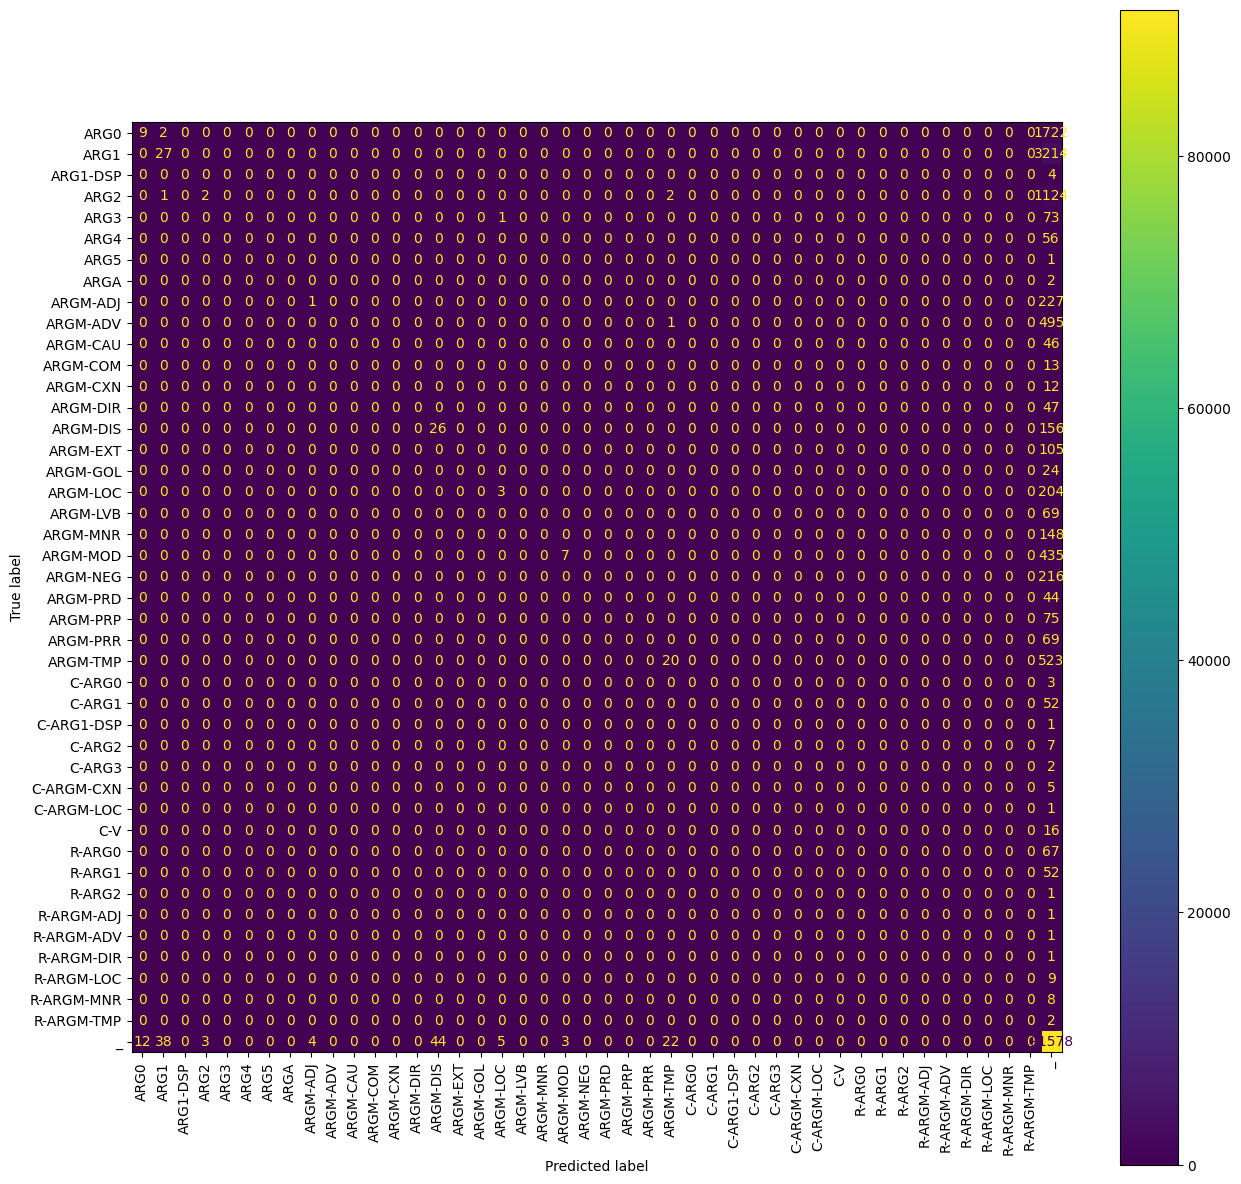

('              precision    recall  f1-score   support\n\n        ARG0      0.429     0.005     0.010      1733\n        ARG1      0.397     0.008     0.016      3241\n    ARG1-DSP      0.000     0.000     0.000         4\n        ARG2      0.400     0.002     0.004      1129\n        ARG3      0.000     0.000     0.000        74\n        ARG4      0.000     0.000     0.000        56\n        ARG5      0.000     0.000     0.000         1\n        ARGA      0.000     0.000     0.000         2\n    ARGM-ADJ      0.200     0.004     0.009       228\n    ARGM-ADV      0.000     0.000     0.000       496\n    ARGM-CAU      0.000     0.000     0.000        46\n    ARGM-COM      0.000     0.000     0.000        13\n    ARGM-CXN      0.000     0.000     0.000        12\n    ARGM-DIR      0.000     0.000     0.000        47\n    ARGM-DIS      0.371     0.143     0.206       182\n    ARGM-EXT      0.000     0.000     0.000       105\n    ARGM-GOL      0.000     0.000     0.000        24\n    AR

In [19]:
evaluation_model(test_golds,preds)